***Importing Required Libraries***

In [694]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


import re
import time
import nltk
import praw
import string
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec, CoherenceModel


from sklearn.model_selection import train_test_split

import nltk
from nltk.collocations import *
from nltk import FreqDist, word_tokenize
from nltk.corpus import gutenberg, stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from keras.preprocessing import text
from keras.models import Model, model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Acquiring User Likes


## Using Twitter API

In [455]:
def get_liked_tweets(handle):
    '''
    Takes Twitter handle and extracts and parses liked tweets.
    
    '''
    ### Acquired from Twitter using API key and API secret key ###
    bearer_token = 'AAAAAAAAAAAAAAAAAAAAAImyAwEAAAAAyWB9oAfMqhJG66%2BeJHuUEi5wsXM%3DKOzTDPgjqoXjzERO1JmoAJfVIqjnaPdD7wUhayNjESzeytty2J'
    ###
    all_tweets = []
    url = 'https://api.twitter.com/1.1/favorites/list.json?screen_name={}'.format(handle)
    headers = {
        'Authorization': 'Bearer {}'.format(bearer_token),
            }
    first_url_params = {
        'count': 200
            }
    first_response = requests.get(url, headers=headers, params=first_url_params)
    print(first_response)
    first_initial_split = first_response.text.split(',"text":"')
    first_t = len(first_initial_split)    
    for i in range(1,first_t):
        all_tweets.append(first_initial_split[i].split(',"truncated":')[0])
        
    ### Regex to extract the id of the last tweet to use as pagination ###      
    regsearch = re.search('(?<=(\d","id":))[\d]*', first_initial_split[first_t-2])
    tweet_id = int(regsearch.group(0))
    ###
    
    ### Looping process to manually paginate through tweets ###
    page = 0
    while page < 15:
        url1 = 'https://api.twitter.com/1.1/favorites/list.json?screen_name={}&count=200&max_id={}'.format(handle,tweet_id-1)
        response = requests.get(url1, headers=headers)
        initial_split = response.text.split(',"text":"')
        t = len(initial_split)
        for i in range(1,t):
            all_tweets.append(initial_split[i].split(',"truncated":')[0])
 
        ### Regex to extract the id of the last tweet to use as pagination ###      
        try:
            regsearch = re.search('(?<=(\d","id":))[\d]*', initial_split[t-2])
            tweet_id = int(regsearch.group(0))
        except: break
        ###
        
        page +=1
    return all_tweets

# Getting Top Subreddits

In [206]:
driver = webdriver.Chrome()
driver.get('https://www.reddit.com/r/TheoryOfReddit/comments/1f7hqc/the_200_most_active_subreddits_categorized_by/')

In [207]:
subs = driver.find_elements_by_class_name('_1qeIAgB0cPwnLhDF9XSiJM')
subreddits = []
for i in subs[3:]:
    if "r/" in i.text:
        subreddits.append(i.text.split(" - ")[1])
    else:
        continue
### THIS CELL THROWS AN ERROR -- IGNORE IT -- ###

IndexError: list index out of range

In [208]:
clean_subs = []
for sub in subreddits:
    clean_subs.append(sub.split('r/')[1])

## Using PRAW (Python Reddit API Wrapper) to get top posts in top subreddits

In [727]:
reddit = praw.Reddit(client_id='MU9yce7zmiOKwA',
                     client_secret='DRV5fO7p-Tn7VzxmMH8mnRwM_hE',
                     user_agent='my user agent')

In [ ]:
all_submissions = {}
for sub in tqdm(clean_subs):
    all_submissions[sub] = []
    for submission in reddit.subreddit(sub).top(limit=1000):
        all_submissions[sub].append(submission.title)
    

## Looking at examples of pre-processing and EDA

In [ ]:
lemmatizer = WordNetLemmatizer()

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
subr_text_tokens_raw = nltk.regexp_tokenize(" ".join(all_submissions['creepy']), pattern)
subr_text_tokens = [word.lower() for word in subr_text_tokens_raw]
subr_text_tokens = [lemmatizer.lemmatize(i) for i in subr_text_tokens]
subr_text_freqdist = FreqDist(subr_text_tokens)
subr_text_freqdist.most_common(200)

In [ ]:
subr_text_stopped_freqdist = FreqDist(subr_text_stopped)
subr_text_stopped_freqdist.most_common(50)

In [ ]:
total_word_count = sum(subr_text_stopped_freqdist.values())
subr_text_top_50 = subr_text_stopped_freqdist.most_common(50)
print("Word\t\t\tNormalized Frequency")
for word in subr_text_top_50:
    normalized_frequency = word[1] / total_word_count
    print("{} \t\t\t {:.4}".format(word[0], normalized_frequency))

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

subr_text_finder = BigramCollocationFinder.from_words(subr_text_stopped)
subr_text_finder.apply_freq_filter(3)

subr_text_scored = subr_text_finder.score_ngrams(bigram_measures.pmi)
subr_text_scored[:20]

# Separating subreddits into respective categories

In [ ]:
label_text_df = pd.DataFrame()

label_text_df['target'] = ['Discussion and Stories','Emotional Reaction Fuel','Entertainment - Gaming', 
                         'Entertainment - Television', 'Entertainment - Other (Movies/Music/Franchies/Misc)',
                         'Humor','Images, Gifs, and Videos','Learning and Thinking','Lifestyle and Help',
                         'News and Issues', 'Places', 'Race, Gender, and Identity', 'Sports','Technology']
categorized_posts = dict((i,"")for i in label_text_df.target)
for i in clean_subs:
    if i =="AskReddit" or i=='IAmA' or i =="bestof" or i=='fatpeoplestories' or i =='pettyrevenge' or i =="TalesFromRetail" or i=='DoesAnybodyElse' or i =='CrazyIdeas':
        categorized_posts['Discussion and Stories'] = [categorized_posts['Discussion and Stories'],all_submissions[i]]
    elif i =="WTF" or i=='aww' or i =="cringepics" or i=='JusticePorn' or i =='MorbidReality' or i =="rage" or i=='mildlyinfuriating' or i =='creepy' or i=='creepyPMs' or i =="nosleep" or i=='nostalgia':
        categorized_posts['Emotional Reaction Fuel'] = [categorized_posts['Emotional Reaction Fuel'],all_submissions[i]]
    elif i =="gaming" or i=='leagueoflegends' or i =="pokemon" or i=='Minecraft' or i =='starcraft' or i =="Games" or i=='DotA2' or i =='skyrim' or i=='tf2' or i =="magicTCG" or i=='wow' or i =="KerbalSpaceProgram" or i=='mindcrack' or i =='Fallout' or i=='roosterteeth' or i =="Planetside" or i=='gamegrumps' or i =="battlefield3" or i=='zelda' or i =='darksouls' or i=='masseffect':
        categorized_posts['Entertainment - Gaming'] = [categorized_posts['Entertainment - Gaming'],all_submissions[i]]
    elif i =="arresteddevelopment" or i=='gameofthrones' or i =="doctorwho" or i=='mylittlepony' or i =='community' or i =="breakingbad" or i=='adventuretime' or i =='startrek' or i=='TheSimpsons' or i =="futurama" or i=='HIMYM' or i=='DunderMifflin' or i =="thewalkingdead":
        categorized_posts['Entertainment - Television'] = [categorized_posts['Entertainment - Television'],all_submissions[i]]
    elif i =="Music" or i=='movies' or i =="harrypotter" or i=='StarWars' or i =='DaftPunk' or i =="hiphopheads" or i=='anime' or i =='comicbooks' or i=='geek' or i =="batman" or i=='TheLastAirbender' or i=='Naruto' or i =="FanTheories":
        categorized_posts['Entertainment - Other (Movies/Music/Franchies/Misc)'] = [categorized_posts['Entertainment - Other (Movies/Music/Franchies/Misc)'],all_submissions[i]]
    elif i =="funny" or i=='AdviceAnimals' or i =="fffffffuuuuuuuuuuuu" or i=='4chan' or i =='ImGoingToHellForThis' or i =="firstworldanarchists" or i=='circlejerk' or i =='MURICA' or i=='facepalm' or i =="Jokes" or i=='wheredidthesodago' or i=='polandball' or i =="TrollXChromosomes" or i =="comics" or i=='nottheonion' or i=='britishproblems' or i =="TumblrInAction" or i =="onetruegod":
        categorized_posts['Humor'] = [categorized_posts['Humor'],all_submissions[i]]
    elif i =="pics" or i=='videos' or i =="gifs" or i=='reactiongifs' or i =='mildlyinteresting' or i =="woahdude" or i=='FiftyFifty' or i =='FoodPorn' or i=='HistoryPorn' or i =="wallpapers" or i=='youtubehaiku' or i=='Unexpected' or i =="photoshopbattles" or i =="AnimalsBeingJerks" or i=='cosplay' or i=='EarthPorn' or i =="QuotesPorn" or i =="awwnime" or i =="AbandonedPorn" or i=='carporn' or i =="PerfectTiming" or i=='OldSchoolCool' or i =='RoomPorn' or i =="woahdude" or i=='Pareidolia' or i =='MapPorn' or i=='tumblr' or i =="techsupportgore" or i=='PrettyGirls' or i=='itookapicture':
        categorized_posts['Images, Gifs, and Videos'] = [categorized_posts['Images, Gifs, and Videos'],all_submissions[i]]
    elif i =="todayilearned" or i=='science' or i =="askscience" or i=='space' or i =='AskHistorians' or i =="YouShouldKnow" or i=='explainlikeimfive':
        categorized_posts['Learning and Thinking'] = [categorized_posts['Learning and Thinking'],all_submissions[i]]
    elif i =="trees" or i=='MakeupAddiction' or i =="cats" or i=='LifeProTips' or i =='RedditLaqueristas' or i =="Random_Acts_Of_Amazon" or i=='food' or i =='guns' or i=='tattoos' or i =="corgi" or i=='teenagers' or i =='GetMotivated' or i=='motorcycles' or i =="sex" or i=='progresspics' or i =='DIY' or i=='bicycling' or i =="Fitness" or i=='lifehacks' or i =='longboarding' or i=='Frugal' or i =="drunk" or i=='Art' or i=='loseit' or i =='Military':
        categorized_posts['Lifestyle and Help'] = [categorized_posts['Lifestyle and Help'],all_submissions[i]]
    elif i =="politics" or i=='worldnews' or i =="news" or i=='conspiracy' or i =='Libertarian' or i =="TrueReddit" or i=='Conservative' or i=='offbeat':
        categorized_posts['News and Issues'] = [categorized_posts['News and Issues'],all_submissions[i]]
    elif i =="canada" or i=='toronto' or i =="australia" or i=='unitedkingdom':
        categorized_posts['Places'] = [categorized_posts['Places'],all_submissions[i]]
    elif i =="atheism" or i=='TwoXChromosomes' or i =="MensRights" or i=='gaybros' or i =='lgbt':
        categorized_posts['Race, Gender, and Identity'] = [categorized_posts['Race, Gender, and Identity'],all_submissions[i]]
    elif i =="nba" or i=='soccer' or i =="hockey" or i=='nfl' or i =='formula1' or i =="baseball" or i=='MMA' or i=='SquaredCircle':
        categorized_posts['Sports'] = [categorized_posts['Sports'],all_submissions[i]]
    elif i =="technology" or i=='Android' or i =="Bitcoin" or i=='programming' or i =='apple':
        categorized_posts['Technology'] = [categorized_posts['Technology'],all_submissions[i]]

## Creating dataframe of posts and categories

In [ ]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i
posts_by_category = dict((i,"")for i in label_text_df.target)
for i in label_text_df.target:
    posts_by_category[i] = list(flatten(categorized_posts[i]))[1:]

In [ ]:
master_list = []
for i in tqdm(label_text_df.target):
    for post in posts_by_category[i]:
        post_list = []
        post_list.append(i)
        post_list.append(post)
        master_list.append(post_list)

reddit_df = pd.DataFrame(master_list)
reddit_df.to_csv('reddit_df') ### Saving dataframe

In [ ]:
reddit_df = pd.read_csv('reddit_df') ### Loading dataframe
reddit_df = reddit_df.drop(columns=["Unnamed: 0"])
reddit_df.columns = reddit_df.columns.astype("int")

In [261]:
from gensim import corpora

In [275]:
dictionary = corpora.Dictionary(reddit_df_stopped['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.66, keep_n=20000)

In [293]:
dictionary.token2id

{'holding': 0,
 'last': 1,
 'people': 2,
 'shit': 3,
 'still': 4,
 'years': 5,
 'yet': 6,
 'away': 7,
 'lee': 8,
 'old': 9,
 'passed': 10,
 'stan': 11,
 'automatically': 12,
 'crosspost': 13,
 'feature': 14,
 'feel': 15,
 'how': 16,
 'original': 17,
 'post': 18,
 'someone': 19,
 'upvoted': 20,
 'upvotes': 21,
 'would': 22,
 'bans': 23,
 'commercials': 24,
 'law': 25,
 'noises': 26,
 'playing': 27,
 'radio': 28,
 'reddit': 29,
 'stations': 30,
 'them': 31,
 'category': 32,
 'five': 33,
 'is': 34,
 'saying': 35,
 'top': 36,
 'without': 37,
 'anthony': 38,
 'avoid': 39,
 'bed': 40,
 'bourdain': 41,
 'cartoons': 42,
 'day': 43,
 'guy': 44,
 'head': 45,
 'him': 46,
 'lay': 47,
 'life': 48,
 'long': 49,
 'movies': 50,
 'my': 51,
 'pot': 52,
 'said': 53,
 'series': 54,
 'smoke': 55,
 'that': 56,
 'theres': 57,
 'wants': 58,
 'watch': 59,
 'who': 60,
 'you': 61,
 'days': 62,
 'difficult': 63,
 'future': 64,
 'headlines': 65,
 'makes': 66,
 'negative': 67,
 'news': 68,
 'optimistic': 69,
 'prog

In [345]:
def turn2numbers(tokens):
    word_tokens = [dictionary.token2id[token] for token in tokens if token in dictionary.token2id]
    return word_tokens

In [300]:
reddit_df_stopped['filtered'] = reddit_df_stopped['tokens'].apply(lambda x: turn2numbers(x))

In [301]:
reddit_df_stopped.head()

,0,1,full_text,tokens,filtered
0,Discussion and Stories,"People pooped 2019 yet, still holding last yea...",People pooped yet still holding last years shit,"[people, pooped, yet, still, holding, last, ye...","[2, 6, 4, 0, 1, 5, 3]"
1,Discussion and Stories,Stan Lee passed away 95 years old,Stan Lee passed away years old,"[stan, lee, passed, away, years, old]","[11, 8, 10, 7, 5, 9]"
2,Discussion and Stories,How would feel feature someone upvotes crosspo...,How would feel feature someone upvotes crosspo...,"[how, would, feel, feature, someone, upvotes, ...","[16, 22, 15, 14, 19, 21, 13, 17, 18, 20, 12]"
3,Discussion and Stories,"Reddit, would feel law bans radio stations pla...",Reddit would feel law bans radio stations play...,"[reddit, would, feel, law, bans, radio, statio...","[29, 22, 15, 25, 23, 28, 30, 27, 24, 26, 31]"
4,Discussion and Stories,"Without saying category is, top five?",Without saying category is top five,"[without, saying, category, is, top, five]","[37, 35, 32, 34, 36, 33]"


# Using GloVes multi-dimensional word vectorizer to build baseline models

In [ ]:
target = reddit_df[0]
data = reddit_df[1].map(word_tokenize).values

total_vocabulary = set(word for headline in data for word in headline)
print("There are {} unique tokens in the dataset.".format(len(total_vocabulary)))

In [ ]:
glove = {}
with open('glove.6B.300d.txt', 'rb') as f:
    for line in f:                                    
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
            
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in tqdm(models)]
scores

**Initial results seem low, but, with 14 categories, random guessing would achieve an accuracy of 7.1%. Let's try a Deep Neural Network with an Embedding Layer**

In [ ]:
y = pd.get_dummies(target).values
reddit_df['splitted'] = reddit_df[1].apply(lambda x: x.split())

In [ ]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]
reddit_df['text_lemmatized'] = reddit_df.splitted.apply(lemmatize_text)

In [ ]:
reddit_df[1] = reddit_df.text_lemmatized.apply(lambda x: " ".join(x))

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(reddit_df[1]))
list_tokenized_headlines = tokenizer.texts_to_sequences(reddit_df[1])
X_t = pad_sequences(list_tokenized_headlines, maxlen=100)

In [ ]:
# #########################
# #   CURRENT BEST MODEL  #  --- Epoch 1: 15.6% accurate
# #########################  --- Epoch 50: 49.4%

#embedding_size = 300
# input_ = Input(shape=(50,))
# x = Embedding(20000, embedding_size)(input_)
# x = Dense(750, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)

# x = LSTM(25, return_sequences=True)(x)
# x = GlobalMaxPool1D()(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.2)(x)
# # There are 14 different possible classes, so we use 14 neurons in our output layer
# x = Dense(14, activation='softmax')(x)

# model = Model(inputs=input_, outputs=x)
# model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
# X_train,X_val, y_train,y_val = train_test_split(X_t,y,test_size=0.1,random_state=1)
# model.summary()

**Neural Network initially kept having a val_accuracy of 0... because the data is sitting in order and wasn't shuffled! (the "test_size" is just the very last bit (0.2) of the data, it doesn't choose randomly... fixed with train test split, which shuffles by default**

# Failed - Training Neural Network with stopwords removed from post titles

In [312]:
reddit_df_stopped

,0,1,full_text,tokens,filtered
0,Discussion and Stories,"People pooped 2019 yet, still holding last yea...",People pooped yet still holding last years shit,"[people, pooped, yet, still, holding, last, ye...","[2, 6, 4, 0, 1, 5, 3]"
1,Discussion and Stories,Stan Lee passed away 95 years old,Stan Lee passed away years old,"[stan, lee, passed, away, years, old]","[11, 8, 10, 7, 5, 9]"
2,Discussion and Stories,How would feel feature someone upvotes crosspo...,How would feel feature someone upvotes crosspo...,"[how, would, feel, feature, someone, upvotes, ...","[16, 22, 15, 14, 19, 21, 13, 17, 18, 20, 12]"
3,Discussion and Stories,"Reddit, would feel law bans radio stations pla...",Reddit would feel law bans radio stations play...,"[reddit, would, feel, law, bans, radio, statio...","[29, 22, 15, 25, 23, 28, 30, 27, 24, 26, 31]"
4,Discussion and Stories,"Without saying category is, top five?",Without saying category is top five,"[without, saying, category, is, top, five]","[37, 35, 32, 34, 36, 33]"
5,Discussion and Stories,"Anthony Bourdain said ""There's guy head, wants...",Anthony Bourdain said Theres guy head wants la...,"[anthony, bourdain, said, theres, guy, head, w...","[38, 41, 53, 57, 44, 45, 58, 47, 40, 43, 49, 5..."
6,Discussion and Stories,"With negative headlines dominating news days, ...",With negative headlines dominating news days d...,"[with, negative, headlines, dominating, news, ...","[74, 67, 65, 68, 62, 63, 72, 71, 70, 73, 66, 6..."
7,Discussion and Stories,"[Serious] Americans, would support putting law...",Serious Americans would support putting law pl...,"[serious, americans, would, support, putting, ...","[89, 75, 22, 90, 87, 25, 85, 80, 83, 88, 86, 7..."
8,Discussion and Stories,Iceland announced every Icelander age 18 autom...,Iceland announced every Icelander age automat...,"[iceland, announced, every, icelander, age, au...","[98, 94, 97, 93, 12, 95, 100, 96, 92, 99, 101,..."
9,Discussion and Stories,How would feel law requires people age 70 pass...,How would feel law requires people age pass s...,"[how, would, feel, law, requires, people, age,...","[16, 22, 15, 25, 107, 2, 93, 106, 108, 104, 10..."


In [271]:
def lemmatize_speech_text(text):
    return [w.lower() for w in nltk.word_tokenize(text)]
reddit_df_stopped['tokens'] = reddit_df_stopped['full_text'].apply(lambda x: lemmatize_speech_text(x))

In [219]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

reddit_df_stopped = pd.DataFrame()
reddit_df_stopped[0] = reddit_df[0]
reddit_df_stopped[1] = reddit_df[1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
reddit_df_stopped['full_text'] = reddit_df_stopped[1].apply(lambda x: re.sub(r'[^\w\s]', '', x))
reddit_df_stopped['full_text'] = reddit_df_stopped['full_text'].apply(lambda x: re.sub(r'[\d]', '', x))


In [304]:
reddit_df_stopped.head()

,0,1,full_text,tokens,filtered
0,Discussion and Stories,"People pooped 2019 yet, still holding last yea...",People pooped yet still holding last years shit,"[people, pooped, yet, still, holding, last, ye...","[2, 6, 4, 0, 1, 5, 3]"
1,Discussion and Stories,Stan Lee passed away 95 years old,Stan Lee passed away years old,"[stan, lee, passed, away, years, old]","[11, 8, 10, 7, 5, 9]"
2,Discussion and Stories,How would feel feature someone upvotes crosspo...,How would feel feature someone upvotes crosspo...,"[how, would, feel, feature, someone, upvotes, ...","[16, 22, 15, 14, 19, 21, 13, 17, 18, 20, 12]"
3,Discussion and Stories,"Reddit, would feel law bans radio stations pla...",Reddit would feel law bans radio stations play...,"[reddit, would, feel, law, bans, radio, statio...","[29, 22, 15, 25, 23, 28, 30, 27, 24, 26, 31]"
4,Discussion and Stories,"Without saying category is, top five?",Without saying category is top five,"[without, saying, category, is, top, five]","[37, 35, 32, 34, 36, 33]"


In [306]:
# tokenizer = text.Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(list(reddit_df_stopped['tokens']))
# list_tokenized_headlines = tokenizer.texts_to_sequences(reddit_df_stopped['full_text'])
X_t = pad_sequences(reddit_df_stopped['filtered'], maxlen=50)

In [309]:
embedding_size = 300
input_ = Input(shape=(50,))
x = Embedding(20000, embedding_size)(input_)
x = Dense(750, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)

x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)
# There are 14 different possible classes, so we use 14 neurons in our output layer
x = Dense(14, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
X_train,X_val, y_train,y_val = train_test_split(X_t,y,test_size=0.3,random_state=1)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dense_22 (Dense)             (None, 50, 750)           225750    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 25)            77600     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 25)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 500)               13000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0  

In [310]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, epochs=100, batch_size=500, callbacks=[earlyStopping,mcp_save], shuffle=True, validation_data=(X_val,y_val))


/Users/reuben/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 121138 samples, validate on 51917 samples
Epoch 1/100
121138/121138 [==============================] - 422s 3ms/step - loss: 7.2775 - accuracy: 0.1664 - val_loss: 2.4026 - val_accuracy: 0.1822
Epoch 2/100
121138/121138 [==============================] - 469s 4ms/step - loss: 2.2440 - accuracy: 0.2056 - val_loss: 2.1583 - val_accuracy: 0.2449
Epoch 3/100
121138/121138 [==============================] - 469s 4ms/step - loss: 2.0786 - accuracy: 0.2727 - val_loss: 2.0639 - val_accuracy: 0.3053
Epoch 4/100
121138/121138 [==============================] - 339s 3ms/step - loss: 1.9810 - accuracy: 0.3268 - val_loss: 1.9946 - val_accuracy: 0.3343
Epoch 5/100
121138/121138 [==============================] - 368s 3ms/step - loss: 1.9043 - accuracy: 0.3634 - val_loss: 1.9499 - val_accuracy: 0.3608
Epoch 6/100
121138/121138 [==============================] - 392s 3ms/step - loss: 1.8296 - accuracy: 0.3979 - val_loss: 1.9095 - val_accuracy: 0.3814
Epoch 7/100
121138/121138 [================

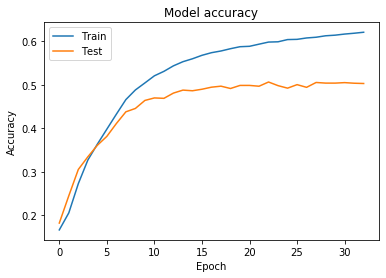

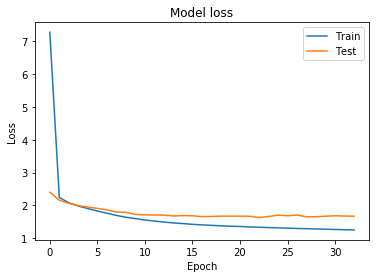

In [311]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(X_val,y_val) ###  Quick sanity check

# Success - Doc2Vec Model

In [510]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [512]:
data = reddit_df_stopped.full_text
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

KeyboardInterrupt: 

In [480]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/Users/reuben/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/reuben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

# Calculating probability of what category you like based on tweets!

In [674]:
def RedditCategoryPredictor():
    twitter_handle = input("What is your Twitter Handle?")
    likes = get_liked_tweets(twitter_handle)
    print("Grabbed {} likes".format(len(likes)))     
    
    joined_words = []
    for i in set(likes):
        joined_words.append("".join(i))
    posts_df = pd.DataFrame(joined_words)
    posts_df['full_text'] = posts_df[0].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    posts_df['full_text'] = posts_df['full_text'].apply(lambda x: re.sub(r'[\d]', '', x))
    posts_df['final'] = posts_df['full_text'].apply(lambda x: x.split())

    dictionary = corpora.Dictionary(posts_df['final'])
    dictionary.filter_extremes(no_below=10, no_above=0.66, keep_n=20000)    
    tokens =list(flatten(posts_df['final']))
    new_vector = model.infer_vector(tokens)
    sims = model.docvecs.most_similar([new_vector],topn=50)
    final_results = []
    for i in sims:
        final_results.append(reddit_df_stopped.iloc[int(i[0])][0])
    cnt = Counter()
    for i in final_results:
        cnt[i] += 1
    print(max(cnt))
    return max(cnt)


In [675]:
techcrunch = RedditCategoryPredictor()

What is your Twitter Handle?techcrunch
<Response [200]>
Grabbed 3745 likes
Technology


# LDA and Topic Modeling

In [682]:
list(reddit_df_stopped.tokens)[:1]

[['people', 'pooped', 'yet', 'still', 'holding', 'last', 'years', 'shit']]

In [685]:
texts = list(reddit_df_stopped.tokens)
corpus = [dictionary.doc2bow(text) for text in texts]

In [691]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [699]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.49838105430777

Coherence Score:  nan


In [702]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/Users/reuben/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.189303 -0.362577       1        1  9.930892
15    -0.282106 -0.101788       2        1  7.715640
10    -0.165948 -0.044775       3        1  7.323079
0     -0.054930 -0.102846       4        1  7.223683
3      0.041270 -0.001845       5        1  6.579432
7      0.027373 -0.002763       6        1  6.520523
9     -0.035018 -0.153411       7        1  6.248676
12     0.089550  0.049452       8        1  5.366909
16     0.106337  0.000414       9        1  5.303156
5      0.040870  0.039818      10        1  5.204773
14    -0.039629  0.051099      11        1  4.833316
17     0.135708  0.020997      12        1  4.760856
4     -0.075144  0.084674      13        1  3.877150
18     0.082693  0.090114      14        1  3.635063
6     -0.035334  0.061308      15        1  3.570916
2      0.000582  0.090299      16        1  3.406919
1      0.038775  0.089882      17        1  2.937725
13    -0.001520  0.088816      18        1  2.780329
11     0.108962  0.107172      19        1  2.738732
19    -0.171795 -0.004041      20        1  0.042225, topic_info=    Category          Freq        Term         Total  loglift  logprob
14   Default  22555.000000         the  22555.000000  30.0000  30.0000
11   Default   8732.000000         new   8732.000000  29.0000  29.0000
60   Default   7684.000000         one   7684.000000  28.0000  28.0000
27   Default   6904.000000          it   6904.000000  27.0000  27.0000
4    Default   7022.000000           a   7022.000000  26.0000  26.0000
132  Default   5096.000000        year   5096.000000  25.0000  25.0000
70   Default   5815.000000        time   5815.000000  24.0000  24.0000
516  Default   6457.000000       years   6457.000000  23.0000  23.0000
286  Default   4766.000000         get   4766.000000  22.0000  22.0000
30   Default   6626.000000        this   6626.000000  21.0000  21.0000
160  Default   5154.000000        like   5154.000000  20.0000  20.0000
401  Default   4689.000000        game   4689.000000  19.0000  19.0000
203  Default   4305.000000      people   4305.000000  18.0000  18.0000
112  Default   4849.000000          my   4849.000000  17.0000  17.0000
547  Default   3708.000000        ever   3708.000000  16.0000  16.0000
173  Default   4854.000000       today   4854.000000  15.0000  15.0000
111  Default   4451.000000        made   4451.000000  14.0000  14.0000
468  Default   3395.000000          we   3395.000000  13.0000  13.0000
266  Default   3933.000000         how   3933.000000  12.0000  12.0000
129  Default   4326.000000        last   4326.000000  11.0000  11.0000
257  Default   4010.000000        make   4010.000000  10.0000  10.0000
58   Default   3802.000000         got   3802.000000   9.0000   9.0000
503  Default   3973.000000       would   3973.000000   8.0000   8.0000
549  Default   3223.000000        know   3223.000000   7.0000   7.0000
48   Default   3779.000000       still   3779.000000   6.0000   6.0000
151  Default   3616.000000         you   3616.000000   5.0000   5.0000
113  Default   3307.000000         now   3307.000000   4.0000   4.0000
424  Default   3569.000000          if   3569.000000   3.0000   3.0000
320  Default   3717.000000         use   3717.000000   2.0000   2.0000
46   Default   2837.000000          is   2837.000000   1.0000   1.0000
..       ...           ...         ...           ...      ...      ...
289  Topic20      0.212059       China      1.528970   5.7944  -6.6039
242  Topic20      0.212059        just      1.529927   5.7938  -6.6039
251  Topic20      0.212059     article      1.529078   5.7944  -6.6039
250  Topic20      0.212059    announce      1.529070   5.7944  -6.6039
249  Topic20      0.212059     Excited      1.528970   5.7944  -6.6039
248  Topic20      0.212059         thu      1.528970   5.7944  -6.6039
247  Topic20      0.212059      thanks      1.529434   5.7941  -6.6039
246  Topic20      0.21

# Getting Related Subreddits

In [210]:
driver = webdriver.Chrome()
driver.get('https://anvaka.github.io/redsim/')

In [212]:
related_subreddits = {}
for i in clean_subs:
    searchbox = driver.find_element_by_id('search-input')
    searchbox.send_keys(i)
    driver.find_element_by_class_name('btn').click()
    result_subs = driver.find_elements_by_xpath("//div[contains(@ng-repeat, 'sub in to')]")
    for s in result_subs:
        related_subreddits.setdefault(i,[]).append(s.text) 
    driver.find_element_by_id('search-input').clear()
        

In [254]:
driver = webdriver.Chrome()
for related_subs in tqdm(list(related_subreddits.values())):
    for sub in related_subs:
        driver.get('https://www.reddit.com/r/{}'.format(sub))
        try:
            driver.find_element_by_class_name('_1jefpljVGT-eHObg40F8Dm')
            related_subs.remove(sub)
        except:
            continue

In [742]:
all_related_posts = {}
for related_subs_key,related_subs_val in tqdm(list(related_subreddits.items())):
    related_sub_posts = []
    for sub in tqdm(related_subs_val):
        new_str = ""
        try:
            for submission in reddit.subreddit(sub).top(limit=1000):
                new_str = new_str + submission.title + " "
        except:
            continue
        related_sub_posts.append((new_str,sub,related_subs_key))
    all_related_posts[related_subs_key] = related_sub_posts

In [812]:
related_subdf = {}
for parent_sub in tqdm(list(related_subreddits.keys())):
    for sub_tuple in all_related_posts[parent_sub]:
        related_subdf[sub_tuple[1]] = sub_tuple[0]

In [834]:
related_subdf = pd.DataFrame.from_dict(related_subdf,orient='index')


TypeError: 'numpy.ndarray' object is not callable

In [837]:
related_subdf.to_csv('related_subdf')

In [839]:
related_subdf.head(2)

,0
funny,My cab driver tonight was so excited to share ...
pics,"Private Internet Access, a VPN provider, takes..."


In [856]:
related_subdf['clean_text'] = related_subdf[0].apply(lambda x: re.sub(r'[^\w\s]', '', x))
related_subdf['clean_text'] = related_subdf['clean_text'].apply(lambda x: re.sub(r'[\d]', '', x))

In [850]:
def tokenize(text):
    return word_tokenize(text)


In [858]:
test_tokenized = tokenize(related_subdf.clean_text[0])

In [853]:
def count_vectorize(text, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(text))
    
    word_dict = {i:0 for i in unique_words}
    
    for word in text:
        word_dict[word] += 1
    
    return word_dict


In [861]:
test_vectorized = count_vectorize(test_tokenized)

In [862]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict   

In [869]:
test_tf = term_frequency(test_vectorized)

In [870]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [882]:
def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

In [1005]:
list(related_subdf.index)

['funny',
 'pics',
 'todayilearned',
 'videos',
 'WTF',
 'AdviceAnimals',
 'gaming',
 'gifs',
 'news',
 'worldnews',
 'movies',
 'technology',
 'science',
 'politics',
 'fatlogic',
 'weeabootales',
 'TalesFromRetail',
 'pettyrevenge',
 'TumblrInAction',
 'ProRevenge',
 'talesfromtechsupport',
 'fatpeoplestories',
 'JusticePorn',
 'TalesFromYourServer',
 'TalesFromTheCustomer',
 'IDontWorkHereLady',
 'NoStupidQuestions',
 'Lightbulb',
 'Unexpected',
 'OutOfTheLoop',
 'mildlyinfuriating',
 'AskReddit',
 'aww',
 'mildlyinteresting',
 'Showerthoughts',
 'cringe',
 'cringepics',
 'PublicFreakout',
 'rage',
 'oddlysatisfying',
 'CrappyDesign',
 'interestingasfuck',
 'facepalm',
 'woahdude',
 'reactiongifs',
 'nottheonion',
 'OldSchoolCool',
 'tifu',
 'Jokes',
 'niceguys',
 'TheBluePill',
 'TrollXChromosomes',
 'iamverysmart',
 'justneckbeardthings',
 'creepy',
 'LetsNotMeet',
 'shortscarystories',
 'WritingPrompts',
 'trashy',
 'summonerschool',
 'hearthstone',
 'nintendo',
 'smashbros',
 '3

In [1006]:
def main(subreddits):
    vectorized_dicts = []
    for sub in tqdm(subreddits[:5]):
        print(sub)
        cleaned_text = related_subdf.loc[sub]['clean_text']
        # Clean and tokenize raw text
        tokenized = tokenize(cleaned_text)
        
        # Get count vectorized representation and store in vectorized_dicts  
        count_vectorized_document = count_vectorize(tokenized)
        vectorized_dicts.append(count_vectorized_document)
        
    # Now that we have a list of BoW respresentations of each song, create a tf-idf representation of everything
    print(vectorized_dicts)
    tf_idf_all_docs = tf_idf(vectorized_dicts)
    
    return tf_idf_all_docs
tf_idf_all_docs = main(list(related_subdf.index))

funny
pics
todayilearned
videos
WTF
[{'There': 3, 'insisted': 1, 'good': 8, 'arent': 3, 'Macy': 1, 'renditions': 1, 'funny': 1, 'House': 1, 'th': 5, 'Jeff': 2, 'bracelet': 1, 'sweet': 1, 'sound': 4, 'safety': 1, 'surprise': 1, 'Id': 2, 'Miami': 1, 'meeting': 1, 'colorizing': 1, 'coach': 1, 'ridiculous': 1, 'embarrass': 1, 'acceptable': 1, 'where': 2, 'stepped': 1, 'acting': 1, 'Chernobyl': 1, 'than': 5, 'eaten': 1, 'kicks': 1, 'pod': 1, 'Shave': 1, 'Hulk': 1, 'gon': 1, 'Try': 1, 'got': 26, 'he': 43, 'Overspending': 1, 'Momoa': 1, 'yearold': 1, 'homeless': 1, 'gram': 1, 'burial': 1, 'asleep': 1, 'Escalation': 1, 'zone': 1, 'Whelp': 1, 'robot': 1, 'Sign': 1, 'Sandstorm': 1, 'sale': 3, 'blood': 1, 'Croatian': 1, 'Go': 1, 'Sweden': 1, 'others': 3, 'OkCupid': 1, 'dancing': 1, 'extra': 2, 'Green': 1, 'Cup': 1, 'you': 34, 'Saw': 4, 'Magicians': 1, 'cam': 2, 'pooping': 1, 'Until': 1, 'showing': 2, 'jacket': 1, 'xpost': 2, 'Police': 1, 'lift': 1, 'Petition': 1, 'Clerk': 1, 'cameraman': 1, 'club

In [1002]:
len(tf_idf_all_docs)

581

In [ ]:
for sub in tf_idf_all_subs:
    pd.DataFrame.

In [930]:
num_dims = len(tf_idf_all_subs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 2989


In [931]:
tf_idf_vals_list = []

for i in tqdm(tf_idf_all_subs):
    tf_idf_vals_list.append(list(i.values()))
    
tf_idf_vals_list[0][:10]

[3, 1, 8, 3, 1, 1, 1, 1, 5, 2]